In [56]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from Elrond.Helpers.array_utility import pandas_collumn_to_2d_numpy_array
from scipy.signal import spectrogram, welch
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path
import pynapple as nap
from scipy.ndimage import gaussian_filter, rotate
from scipy.signal import find_peaks, peak_prominences, spectrogram
from scipy.stats import zscore

from spatial_manifolds.data.binning import get_bin_config
from spatial_manifolds.data.loading import load_session
from spatial_manifolds.util import gaussian_filter_nan
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
mouse = 25
day = 26
session_type = 'MCVR'
sorter = 'kilosort4'
storage = Path('/Users/harryclark/Downloads/nwb_data/')
alpha = 0.001
n_jobs = 8
n_shuffles = 100
seed = 1

class Args:
    def __init__(self,mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed):
        self.mouse = mouse
        self.day = day
        self.session_type = session_type
        self.sorter = sorter
        self.storage = storage
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.n_shuffles = n_shuffles
        self.seed = seed
args = Args(mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed)

if session_type == 'VR':
    tl = 200
elif session_type == 'MCVR':
    tl = 230


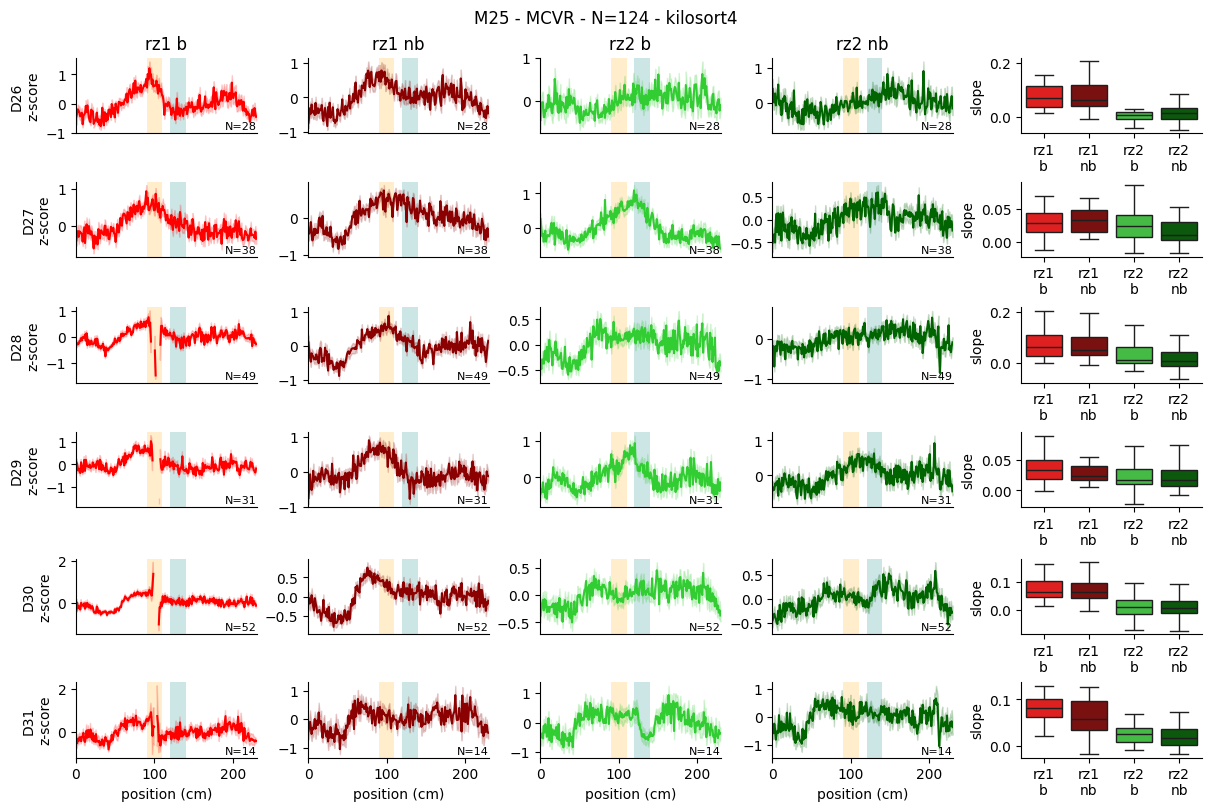

In [58]:
# Load session
sessions = {}
for session_path in sorted(
    list(args.storage.glob(f'sessions/M{args.mouse}/*/MCVR/*MCVR.nwb'))
):
    args.day = int(session_path.parent.parent.name[1:])
    sessions[args.day] = (
        *load_session(args),
        pd.read_parquet(
            session_path.parent / 'tuning_scores' / 'ramp_class.parquet'
        ),
    )
bin_config = get_bin_config(args.session_type)['P']

# Plot
trial_types = [0,1,2,3]
groups = [
    ('rz1_b', (0, 1), 'red'),
    ('rz1_nb', (0, 1), 'darkred'),
    ('rz2_b', (2, 3), 'limegreen'),
    ('rz2_nb', (2, 3), 'darkgreen'),
]

fig, axs = plt.subplots(
    len(sessions), len(trial_types) + 1, layout='constrained', figsize=(12, 8)
)
for day_idx, (
    day,
    (session, session_path, clusters, ramp_class),
) in enumerate(sessions.items()):
    
    # only concerned with cells that have positive outbound ramps in the beaconed and non beaconed trials for context 1
    subset_ids = ramp_class[
        (ramp_class['group'] == 'rz1_b+nb')
        & (ramp_class['sign'] == '+')
        & (ramp_class['region'] == 'outbound')
    ]['cluster_id'].values

    for tt_i, (group, trial_group, color) in enumerate(groups):
        ax = axs[day_idx, tt_i]

        trials = session['trials'][session['trials']['trial_type'] == float(tt_i)]

        tcs = nap.compute_1d_tuning_curves(
            clusters,
            session['P'],
            nb_bins=bin_config['num_bins'],
            minmax=bin_config['bounds'],
            ep=session['moving'].intersect(trials),
        )

        zscored = (tcs[subset_ids] - tcs[subset_ids].mean(axis=0)) / tcs[
            subset_ids
        ].std(axis=0)
        mean = zscored.mean(axis=1)
        sem = zscored.std(axis=1) / np.sqrt(len(subset_ids))
        ax.plot(tcs.index, mean, label=group, color=color)
        ax.fill_between(
            tcs.index, mean - sem, mean + sem, alpha=0.2, color=color
        )
        if tt_i == 0:
            ax.set_ylabel(f'D{day}\nz-score')
        else:
            ax.set_ylabel('')
        if day_idx == 0:
            ax.set_title(f'{group.replace("_", " ")}')
        if day_idx == len(sessions) - 1:
            ax.set_xlabel('position (cm)')
        else:
            ax.xaxis.set_visible(False)
        ax.set_xlim(bin_config['bounds'])
        ax.axvspan(
            90,
            110,
            alpha=0.2,
            zorder=-10,
            edgecolor='none',
            facecolor='orange',
        )
        ax.axvspan(
            120,
            140,
            alpha=0.2,
            zorder=-10,
            edgecolor='none',
            facecolor='teal',
        )
        ax.text(
            1.0,
            0.05,
            f'N={len(subset_ids)}',
            fontsize=8,
            ha='right',
            transform=ax.transAxes,
        )
        sns.despine(top=True, right=True)

    # Slope histogram
    subset = ramp_class[(ramp_class['cluster_id'].isin(subset_ids)) &
                        (ramp_class['region'] == 'outbound') & 
                        (ramp_class['group'].isin(['rz1_b', 'rz1_nb', 'rz2_b', 'rz2_nb']))]
    
    subset['group'] = subset['group'].str.replace('_', '\n')
    sns.boxplot(
        ax=axs[day_idx, -1],
        data=subset,
        x='group',
        hue='group',
        y='slope',
        order=[group.replace('_', '\n') for group, _, _ in groups],
        palette={
            group.replace('_', '\n'): color for group, _, color in groups
        },
        showfliers=False,
    )
    axs[day_idx, -1].set_ylabel('slope')
    axs[day_idx, -1].set_xlabel('')
plt.suptitle(
    f'M{args.mouse} - {args.session_type} - N={len(clusters)} - {args.sorter}'
)
plt.show()


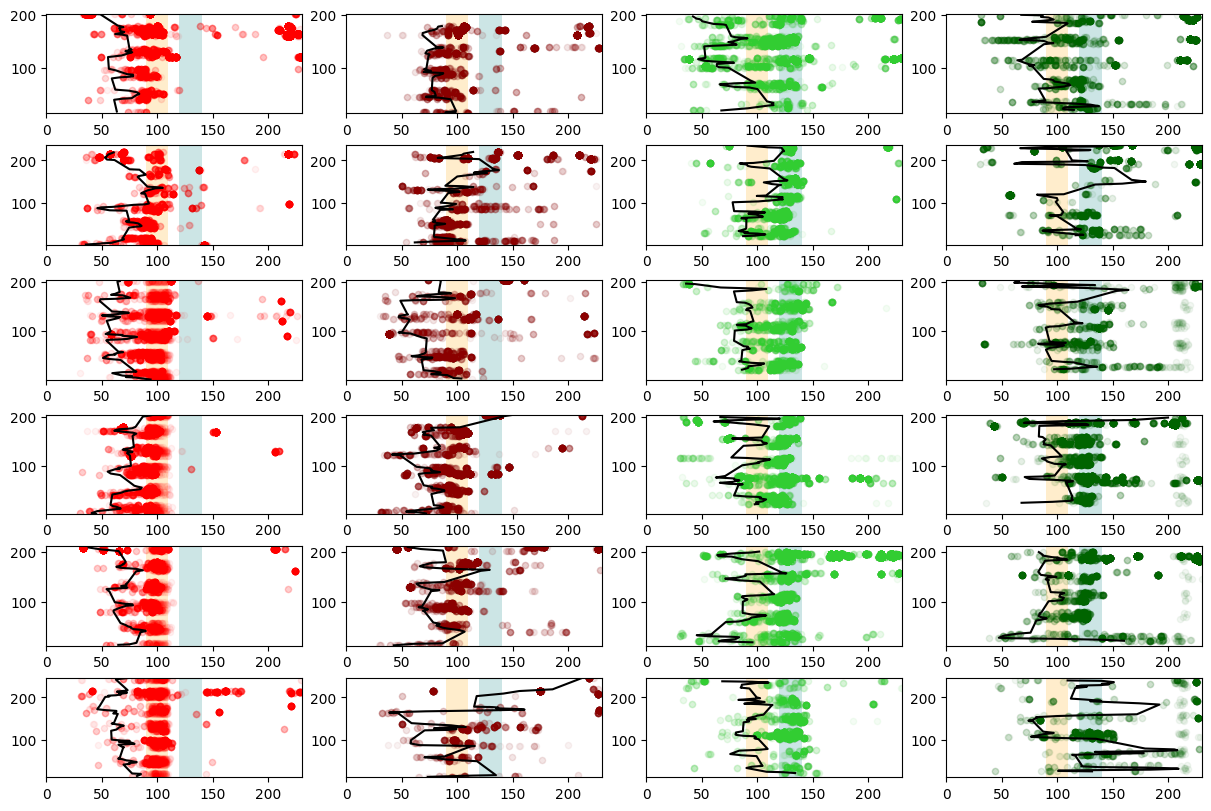

In [59]:
def plot_stop_raster(ax, session, tt, tl, c):
    trial_numbers = np.array(session["trial_number"])
    position = np.array(session['P'])
    trial_types = np.array(session['trial_type'])
    speed = np.array(session['S'])
    stop_mask = speed<3
    tt_mask = trial_types == tt
    track_mask = position>30
    ax.scatter(position[(stop_mask & tt_mask & track_mask)], trial_numbers[(stop_mask & tt_mask & track_mask)], color=c,alpha=0.05, s=20)
    ax.set_xlim(0,tl)
    ax.set_ylim(np.min(trial_numbers),np.max(trial_numbers))
    ax.axvspan(
    90,
    110,
    alpha=0.2,
    zorder=-10,
    edgecolor='none',
    facecolor='orange',
    )
    ax.axvspan(
        120,
        140,
        alpha=0.2,
        zorder=-10,
        edgecolor='none',
        facecolor='teal',
    )

    first_stops = []
    for tn in np.unique(trial_numbers):
        tn_mask = trial_numbers==tn
        trial_stop_locations = position[(stop_mask & tt_mask & tn_mask & track_mask)]
        if len(trial_stop_locations)>0:
            first_stop = trial_stop_locations[0]
        else:
            first_stop = np.nan
        first_stops.append(first_stop)
    first_stops=np.array(first_stops)
    nan_mask = np.isnan(first_stops)
    ax.plot(gaussian_filter1d(first_stops[~nan_mask], sigma=1), 
            np.unique(trial_numbers)[~nan_mask], linestyle='solid', color='black')


# Load session
sessions = {}
for session_path in sorted(
    list(args.storage.glob(f'sessions/M{args.mouse}/*/MCVR/*MCVR.nwb'))
):
    args.day = int(session_path.parent.parent.name[1:])
    sessions[args.day] = (
        *load_session(args),
        pd.read_parquet(
            session_path.parent / 'tuning_scores' / 'ramp_class.parquet'
        ),
    )
bin_config = get_bin_config(args.session_type)['P']

fig, axs = plt.subplots(
    len(sessions), 4, layout='constrained', figsize=(12, 8)
)

for day_idx, (
    day,
    (session, session_path, clusters, ramp_class),
) in enumerate(sessions.items()):
    for tt, c in zip([0,1,2,3], ['red','darkred','limegreen','darkgreen']):
        ax = axs[day_idx, tt]
        plot_stop_raster(ax,session,tt=tt, tl=tl, c=c) 
plt.show()


In [60]:
first_stops

NameError: name 'first_stops' is not defined

In [17]:
trial_numbers = np.array(session["trial_number"])
position = np.array(session['P'])
trial_types = np.array(session['trial_type'])
speed = np.array(session['S'])


In [ ]:
speed

array([ 0.        ,  0.        , -0.38350924, ...,  0.        ,
        0.        ,  0.        ])

In [22]:
moving

array([[4.28447773e-01, 1.89602840e+00],
       [2.01253337e+00, 3.27259939e+00],
       [3.29516153e+00, 4.72118848e+00],
       ...,
       [2.27414820e+03, 2.27429815e+03],
       [2.27599834e+03, 2.27619829e+03],
       [2.27654837e+03, 2.27908156e+03]])